### Data Exploration

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

There are 2 netCDF files containing surface meteorological variables (`oaflux_air_sea_fluxes_train.nc`) and marine heatwave labels (`marine_heatwave_labels_train.nc`). All data is averaged monthly on a 1º global grid from 1981-09-01 through 2015-12-01.

**Load & visualize the data:**

In [2]:
def plot_maps(var, **kwargs):
    '''Creates global maps of data variables using Cartopy'''
    fig = plt.figure(figsize=(8,4)) 
    ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
    ax.coastlines(resolution='110m', color='black', linewidth=1)
    cont = var.plot.contourf(vmin=var.quantile(.2), vmax=var.quantile(.95), transform=ccrs.PlateCarree(), extend='both', add_labels=True, add_colorbar=False)
    cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
    cbar.set_label(kwargs['units'], fontsize=12)
    plt.title(kwargs['title'], fontsize=12) 
    return plt.show()

In [3]:
!ls data/*.nc

data/OAFlux.nc			      data/oaflux_air_sea_fluxes_train.nc
data/marine_heatwave_labels_train.nc  data/preprocessed_OISST.nc
data/mhw_labels.nc


In [39]:
# Marine Heatwave Labels
mhw = xr.open_dataset('data/marine_heatwave_labels_train.nc', engine='netcdf4')
mhw

<xarray.Dataset>
Dimensions:    (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    lsmask     (lat, lon) float32 ...
    mhw_label  (time, lat, lon) float32 ...

In [35]:
# Objectively Analyzed air-sea Fluxes (OAFlux) for the Global Oceans
oaflux = xr.open_dataset('data/oaflux_air_sea_fluxes_train.nc', engine='netcdf4')
oaflux

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    evapr    (time, lat, lon) float32 ...
    lhtfl    (time, lat, lon) float32 ...
    nlwrs    (time, lat, lon) float32 ...
    hum2m    (time, lat, lon) float32 ...
    qnet     (time, lat, lon) float32 ...
    shtfl    (time, lat, lon) float32 ...
    nswrs    (time, lat, lon) float32 ...
    tmp2m    (time, lat, lon) float32 ...
    tmpsf    (time, lat, lon) float32 ...
    wnd10    (time, lat, lon) float32 ...

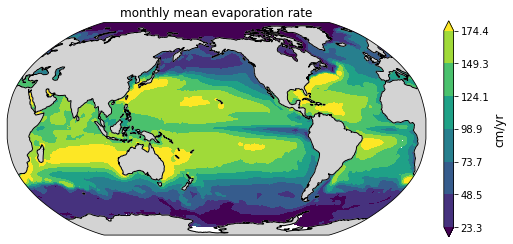

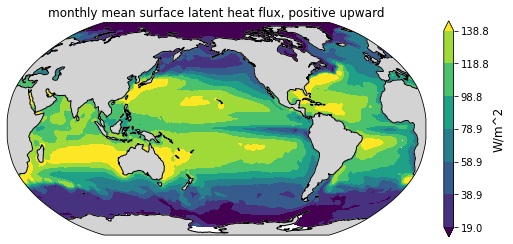

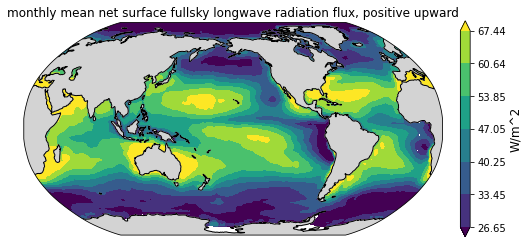

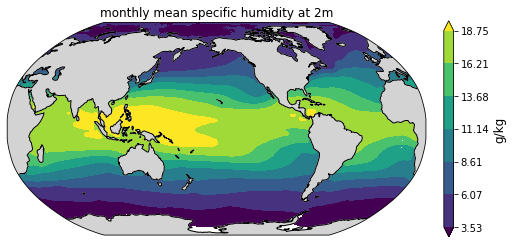

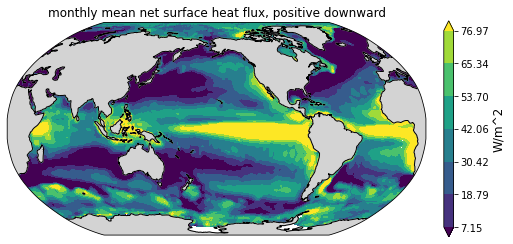

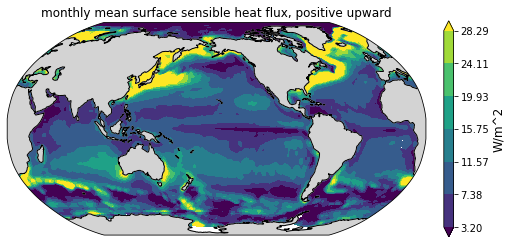

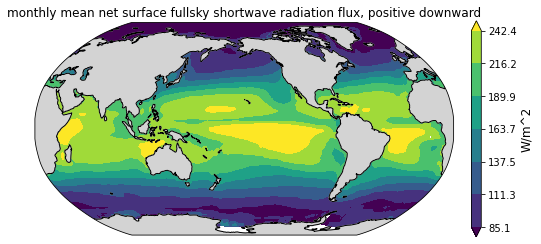

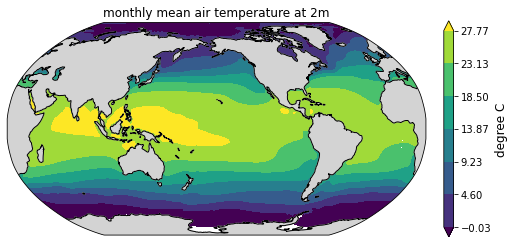

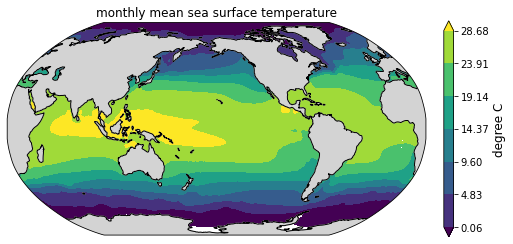

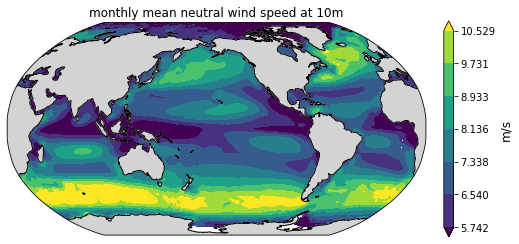

In [36]:
oaflux_mean = oaflux.mean('time', keep_attrs=True)
        
figs = [plot_maps(oaflux_mean[i], units=oaflux_mean[i].attrs['units'], title=oaflux_mean[i].attrs['long_name']) for i in list(oaflux_mean.keys())]

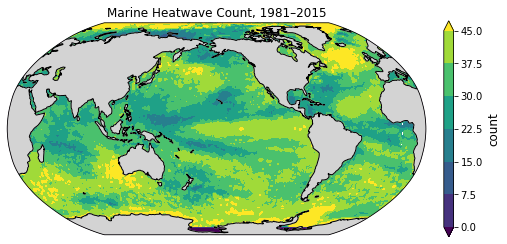

In [58]:
plot_maps(mhw.mhw_label.sum('time', keep_attrs=True), units='count', 
          title=f'Marine Heatwave Count, {mhw.time[0].dt.year.values}–{mhw.time[-1].dt.year.values}')        
